In [1]:
#-- Import libraries --#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import time

#-- Suppress setting with copy warning --#
pd.options.mode.chained_assignment = None

import os
wd = '/Users/kirankrishnamurthi/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Scoring-Concentration'
os.chdir(wd)

In [2]:
#-- Scrape team gamelogs from basketball-reference.com --#

df = pd.DataFrame()

cleaned_col_names = ['Rk', 'G', 'Date', 'H_A', 'Opp_Team', 'W_L', 'Tm', 'Opp'
                     , 'FG', 'FGA', 'FGper', '3P', '3PA', '3Pper', 'FT', 'FTA', 'FTper'
                     , 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'
                     , 'Blank' #-- this is the column seperating team vs. opponent stats
                     , 'Opp_FG', 'Opp_FGA', 'Opp_FGper', 'Opp_3P', 'Opp_3PA'
                     , 'Opp_3Pper', 'Opp_FT', 'Opp_FTA', 'Opp_FTper', 'Opp_ORB'
                     , 'Opp_TRB', 'Opp_AST', 'Opp_STL', 'Opp_BLK', 'Opp_TOV', 'Opp_PF']

team = 'MIL'

#for team in nba_teams:

#-- data request
url = 'https://www.basketball-reference.com/teams/{}/2023/gamelog/'
data = requests.get(url.format(team))

#-- save file to html in write format
#with open('{}_2223_GL.html'.format(team), 'w+') as f:
#    f.write(data.text)

#-- open saved html file
#with open('{}_2223_GL.html'.format(team)) as f:
#    page = f.read()

#-- scrape web page and get rid of unwanted headers
page = data.text
soup = BeautifulSoup(page, 'html.parser')
soup.find('tr', class_ = 'over_header').decompose()
soup.find('tr', class_ = 'over_header thead').decompose()

#-- fetch data and push to df
gamelog = soup.find(id = 'tgl_basic')
team_df = pd.read_html(str(gamelog))[0]

#-- rename columns to fit coding syntax
team_df.columns = cleaned_col_names

#-- create a column for the season ID and team ID
team_df['nba_season'] = 2023
team_df['gamelog_team'] = 'MIL'

#-- append to df
df = pd.concat([df, team_df], axis = 0)

#-- pause to avoid getting blocked
time.sleep(2)

#-- get rid of any rows where table headers are inserted
df = df.loc[(df['Opp'] != 'Opp') & (df['FGper'] != 'Team')]

float_cols = ['FGper', '3Pper', 'FTper', 'Opp_FGper', 'Opp_3Pper', 'Opp_FTper']
int_cols = ['Rk', 'G', 'Tm', 'Opp', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'TRB', 'AST'
            , 'STL', 'BLK', 'TOV', 'PF', 'Opp_FG', 'Opp_FGA', 'Opp_3P', 'Opp_3PA'
            , 'Opp_FT', 'Opp_FTA', 'Opp_ORB', 'Opp_TRB', 'Opp_AST', 'Opp_STL'
            , 'Opp_BLK', 'Opp_TOV', 'Opp_PF']

for col in float_cols:
    df[col] = df[col].astype(float)

for col in int_cols:
    df[col] = df[col].astype(int)

df.reset_index(inplace = True, drop = True)

In [3]:
#-- Create two series for date and team for box-score scraping --#

date_vec = df['Date'].str.replace("-", "") + "0"
team_vec = np.where(df['H_A'] == '@', df['Opp_Team'], df['gamelog_team'])

print(date_vec[4])
print(team_vec[4])

print('https://www.basketball-reference.com/boxscores/{}{}.html'.format(date_vec[4], team_vec[4]))

202210290
MIL
https://www.basketball-reference.com/boxscores/202210290MIL.html


In [4]:
#-- Partition Date and Team Vectors --#

dv1 = date_vec[0:17]
dv2 = date_vec[17:34]
dv3 = date_vec[34:51]
dv4 = date_vec[51:68]
dv5 = date_vec[68:]

tv1 = team_vec[0:17]
tv2 = team_vec[17:34]
tv3 = team_vec[34:51]
tv4 = team_vec[51:68]
tv5 = team_vec[68:]

In [5]:
#-- Date and Team Vector 1 Scraping Loop --#

df = pd.DataFrame()
HHI_DICT = {}

for i, j in zip(dv5, tv5):

#-- data request
    url = 'https://www.basketball-reference.com/boxscores/{}{}.html'
    data = requests.get(url.format(i, j))

    #-- save file to html in write format
    #with open('{}_2223_GL.html'.format(team), 'w+') as f:
    #    f.write(data.text)

    #-- open saved html file
    #with open('{}_2223_GL.html'.format(team)) as f:
    #    page = f.read()

    #-- scrape web page and get rid of unwanted headers
    page = data.text
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_ = 'over_header').decompose()
    
    #-- fetch data and push to df
    box_score = soup.find(id = 'box-MIL-game-basic')
    tbs = pd.read_html(str(box_score))[0]

    #-- get rid of heading multi-index in columns 
    if isinstance(tbs.axes[1], pd.core.indexes.multi.MultiIndex):
        tbs.columns = tbs.columns.droplevel(0)
    else:
        exit()

    #-- get rid of any rows where table headers are inserted
    tbs = tbs.loc[(tbs['MP'] != 'MP') & (tbs['Starters'] != 'Team Totals')]

    #-- remove any rows where player did not play and replace with 0
    for x in range(len(tbs.columns)):
        tbs.iloc[:,x] = np.where( (tbs.iloc[:,x] == 'Did Not Play') | (tbs.iloc[:,x] == 'Did Not Dress'), 0, tbs.iloc[:,x])

    #-- Game Identification Column --#

    tbs['GAMEID'] = str(i) + str(j) + team

    #-- Time Played Caculations --#

    tbs['MIN'] = tbs['MP'].str.split(':').str[0].fillna(0).astype(int)
    tbs['SEC'] = tbs['MP'].str.split(':').str[1].fillna(0).astype(int)
    tbs['TT'] = tbs['MIN'] + tbs['SEC']/60
    tbs['TTSHARE'] = tbs['TT']/ tbs['TT'].sum()

    #-- Points Share Calculations --#

    tbs['PTS'] = tbs['PTS'].astype(int)
    tbs['PTSSHARE'] = tbs['PTS']/ tbs['PTS'].sum()
    tbs['PPM'] = tbs['PTS'] / tbs['TT']
    tbs['PPM_ZSCORE'] = ( tbs['PPM'] - tbs['PPM'].mean() ) / tbs['PPM'].std()
    tbs['EPTS'] = tbs['TTSHARE'] * tbs['PTS'].sum()
    tbs['EPTS_ZSCORE'] = ( tbs['EPTS'] - tbs['EPTS'].mean() ) / tbs['EPTS'].std()
    tbs['EPTS_DIFF'] = tbs['EPTS'] - tbs['PTS']

    #-- Point-Capitalization Style Calculations --#

    tbs['PTSCAP'] = tbs['PTS'] * tbs['TT']
    tbs['PTSCAP_SHARE'] = tbs['PTSCAP'] / tbs['PTSCAP'].sum()

    #-- HHI Calculations --#

    hhi_dict = {
    ('MIL{}{}'.format(i, j), 'MP_HHI') : (tbs['TTSHARE']**2).sum()
    , ('MIL{}{}'.format(i, j), 'PTS_HHI') : (tbs['PTSSHARE']**2).sum()
    , ('MIL{}{}'.format(i, j), 'PTSCAP_HHI') : (tbs['PTSCAP_SHARE']**2).sum()
    }

    df = pd.concat([df, tbs], axis = 0)

    HHI_DICT.update(hhi_dict)

    time.sleep(2)


pd.DataFrame(HHI_DICT, index = [0]).T.to_csv('HHI_DICT_5.csv')
df.to_csv('MIL2223_BOXDATA_5.csv')

: 

In [2]:
d1 = pd.read_csv('MIL2223_BOXDATA_1.csv')
d2 = pd.read_csv('MIL2223_BOXDATA_2.csv')
d3 = pd.read_csv('MIL2223_BOXDATA_3.csv')
d4 = pd.read_csv('MIL2223_BOXDATA_4.csv')
d5 = pd.read_csv('MIL2223_BOXDATA_5.csv')



In [6]:
data = pd.concat([d1, d2, d3, d4, d5])
data.reset_index(inplace = True, drop = True)

<AxesSubplot:xlabel='GAMEID'>

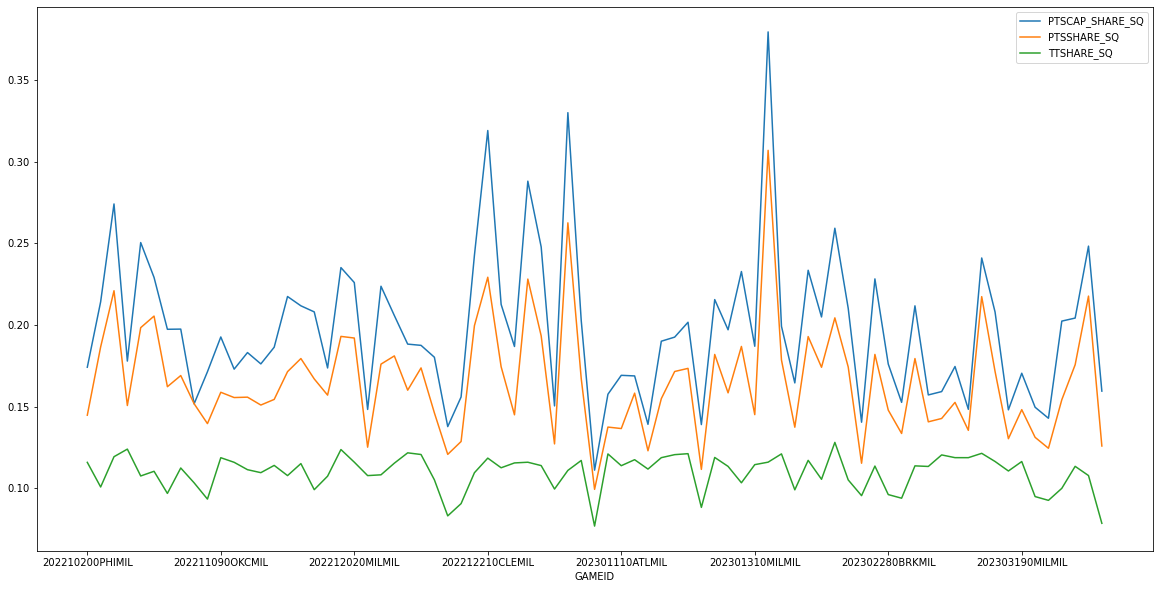

In [19]:
data['TTSHARE_SQ'] = data['TTSHARE']**2
data['PTSSHARE_SQ'] = data['PTSSHARE']**2
data['PTSCAP_SHARE_SQ'] = data['PTSCAP_SHARE']**2

data.pivot_table(
    index = ['GAMEID']
    , values = ['TTSHARE_SQ', 'PTSSHARE_SQ', 'PTSCAP_SHARE_SQ']
    , aggfunc = 'sum'
).plot(figsize = (20, 10))